# Overlapping phytochemicals (natural products in plants) with approved-drugs (Newman dataset)

### Import modules

In [44]:
from collections import defaultdict

import pandas as pd
from tqdm import tqdm
import seaborn as sns

from rdkit import RDLogger  
from rdkit.Chem.inchi import MolToInchi, InchiToInchiKey
from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Descriptors import ExactMolWt
from pubchempy import get_compounds

import matplotlib as mpl
from matplotlib_venn import venn3, venn2
from matplotlib import pyplot as plt

In [2]:
%config Application.log_level='INFO'
import logging
logging.getLogger('s3fs').setLevel(logging.INFO)
logging.getLogger('botocore').setLevel(logging.INFO)
logging.getLogger('fsspec').setLevel(logging.INFO)

In [3]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360

In [4]:
%matplotlib inline

tqdm.pandas()
pd.set_option('display.max_columns', None)

In [5]:
RDLogger.DisableLog('rdApp.*')

Load Newman data

In [6]:
natural_products_df = pd.read_csv(
    's3://enveda-data-kg/others/cdd/newman_natural_products.tsv',
    sep='\t',
    usecols=[
        'curated_name',
        'pubchem_name',
        'pubchem_id',
        'smiles',
    ]
)

synthetics_df = pd.read_csv(
    's3://enveda-data-kg/others/cdd/newman_synthetics.tsv',
    sep='\t',
    usecols=[
        'curated_name',
        'pubchem_name',
        'pubchem_id',
        'smiles',
    ]
)

In [7]:
natural_products_df.shape, synthetics_df.shape

((397, 4), (935, 4))

In [8]:
synthetics_df.head(2)

,curated_name,pubchem_name,pubchem_id,smiles
0,alizapride,6-methoxy-N-[(1-prop-2-enylpyrrolidin-2-yl)met...,135413504,COC1=CC2=C(C=C1C(=O)NCC3CCCN3CC=C)NN=N2
1,amezinium methylsulfate,6-methoxy-1-phenylpyridazin-1-ium-4-amine;meth...,71926,COC1=[N+](N=CC(=C1)N)C2=CC=CC=C2.COS(=O)(=O)[O-]


In [9]:
natural_products_df.head(2)

,curated_name,pubchem_name,pubchem_id,smiles
0,aclarubicin,"methyl (1R,2R,4S)-4-[(2R,4S,5S,6S)-4-(dimethyl...",451415,CC[C@]1(C[C@@H](C2=C(C3=C(C=C2[C@H]1C(=O)OC)C(...
1,Netilmicin sulfate,"(2R,3R,4R,5R)-2-[(1S,2S,3R,4S,6R)-4-amino-3-[[...",62115,CCN[C@@H]1C[C@@H]([C@H]([C@@H]([C@H]1O[C@@H]2[...


In [10]:
smiles_in_data = set(natural_products_df.smiles.unique()).union(
    set(synthetics_df.smiles.unique())
)
len(smiles_in_data)

1313

In [11]:
all_inchikeys = set()
skipped = 0

low_molecular_weights = []

molecular_weights = []

for smiles in tqdm(smiles_in_data):
    try:
        mol = MolFromSmiles(smiles)
    except:
        skipped += 1

    mol_weight = ExactMolWt(mol)

    molecular_weights.append(mol_weight)

    if mol_weight < 150:
        low_molecular_weights.append(smiles)
    
    all_inchikeys.add(InchiToInchiKey(MolToInchi(mol)))

100%|██████████| 1313/1313 [00:01<00:00, 1128.02it/s]


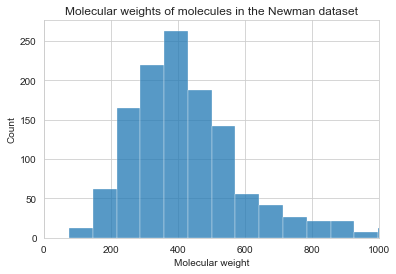

In [12]:
sns.histplot(molecular_weights, bins=100)
plt.title('Molecular weights of molecules in the Newman dataset')
plt.xlabel('Molecular weight')
plt.xlim(0, 1000)
plt.show()

In [13]:
len(all_inchikeys)

1313

This dataset requires an approved license and cant be released by us so this step is not reproducible and the dataset has to be downloaded manually

In [14]:
drugbank_approved_df = PandasTools.LoadSDF(
    '/Users/danieldomingo/Downloads/drugbank_approved.sdf',
    smilesName='SMILES',
    molColName='Molecule',
)

In [15]:
drugbank_approved_df.shape[0]

2587

In [16]:
molecular_weights = []

for smiles in tqdm(drugbank_approved_df.SMILES):
    try:
        mol = MolFromSmiles(smiles)
    except:
        skipped += 1

    molecular_weights.append(ExactMolWt(mol))

100%|██████████| 2587/2587 [00:00<00:00, 3490.48it/s]


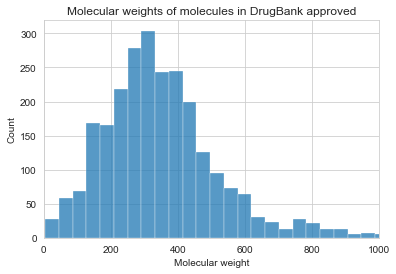

In [17]:
sns.histplot(molecular_weights, bins=100)
plt.title('Molecular weights of molecules in DrugBank approved')
plt.xlabel('Molecular weight')
plt.xlim(0, 1000)
plt.show()

### Load ethnobotanical data

In [18]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
)

medicinal_plants = plant_disease_df.plant_curie.unique()

In [51]:
plant_disease_df.shape[0], len(medicinal_plants)

(97066, 6048)

### Load phytochemical data

In [19]:
# Load Plant to PubChem
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

# Load PubChem to SMILES
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
    
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 89270/89270 [00:00<00:00, 468483.40it/s]


In [52]:
len(smiles_to_pubchem), plant_chemical_df.shape[0], len(plant_chemical_df.plant_curie.unique())

(89270, 389946, 19987)

#### InchiKey overlap

In [21]:
def get_first_part_inchikey(inchikey):
    return inchikey.split('-')[0]

pubchem_to_inchikey = {
    pubchem: InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))
    for pubchem, smiles in tqdm(pubchem_to_smiles.items())
}

natural_products_inchikeys_dict = {
    get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))): name
    for name, smiles in tqdm(natural_products_df[['curated_name', 'smiles']].values)
    if smiles not in low_molecular_weights
}

synthethics_inchikeys_dict = {
    get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))): name
    for name, smiles in tqdm(synthetics_df[['curated_name', 'smiles']].values)
    if smiles not in low_molecular_weights
}

100%|██████████| 935/935 [00:00<00:00, 1188.19it/s]


In [22]:
len(synthethics_inchikeys_dict), len(natural_products_inchikeys_dict), len(set(pubchem_to_inchikey.values()))

(916, 375, 89203)

In [23]:
synthethics_inchikeys = {
    inchikey
    for inchikey in synthethics_inchikeys_dict
}

natural_products_newman_inchikeys = {
    inchikey
    for inchikey in natural_products_inchikeys_dict
}

phytochemicals_inchikey ={
    get_first_part_inchikey(inchikey)
    for inchikey in pubchem_to_inchikey.values()
}

drugbank_inchikeys = {
    get_first_part_inchikey(inchikey)
    for inchikey, mw in drugbank_approved_df[['INCHI_KEY', 'MOLECULAR_WEIGHT']].values
    if float(mw) > 150
}

# Get the ones in the other sets to reduce the number and make a better plot
phytochemicals_inchikey = {
    inchikey
    for inchikey in phytochemicals_inchikey
    if inchikey in natural_products_newman_inchikeys or inchikey in synthethics_inchikeys
}

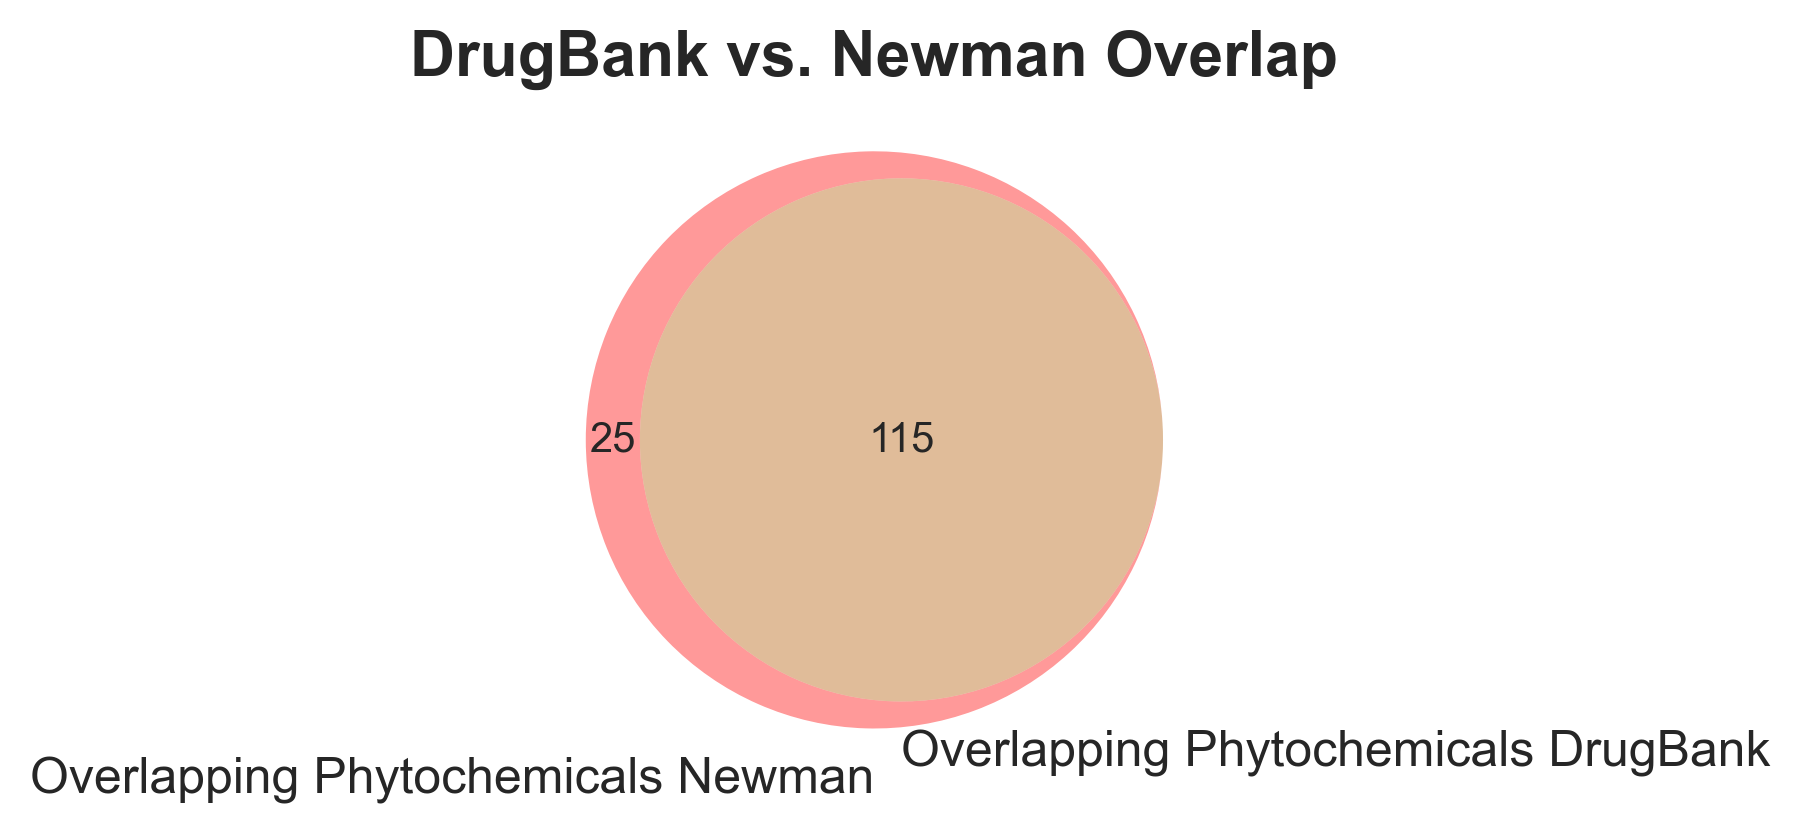

In [24]:
plt.figure(dpi=300, figsize=([3, 3]))
v = venn2([phytochemicals_inchikey, {
        inchikey
        for inchikey in phytochemicals_inchikey
        if inchikey in drugbank_inchikeys
    }], set_labels = ('Overlapping Phytochemicals Newman', 'Overlapping Phytochemicals DrugBank')
)
plt.title('DrugBank vs. Newman Overlap', fontsize=15, fontweight='bold')
v.get_label_by_id('010').set_text('')

plt.show()

In [25]:
coconut_smiles = pd.read_csv(
    'https://coconut.naturalproducts.net/download/smiles',
    names=['smiles'],
    header=None,
)

lotus_smiles = pd.read_csv(
    'https://lotus.naturalproducts.net/download/smiles',
    names=['smiles'],
    header=None,
)


In [26]:
natural_products_smiles = set(lotus_smiles.smiles.unique()).union(set(coconut_smiles.smiles.unique()))

In [27]:
len(natural_products_smiles)

683788

In [28]:
all_natural_products_inchikeys = set()

for smiles in tqdm(natural_products_smiles):
    try:
        mol = MolFromSmiles(smiles)
    except:
        continue
    
    # Skip if there are errors while reading the molecule
    try:
        inchikey = InchiToInchiKey(MolToInchi(mol))
    except:
        continue

    all_natural_products_inchikeys.add(
        get_first_part_inchikey(inchikey)
    )

100%|██████████| 683788/683788 [08:12<00:00, 1387.78it/s]


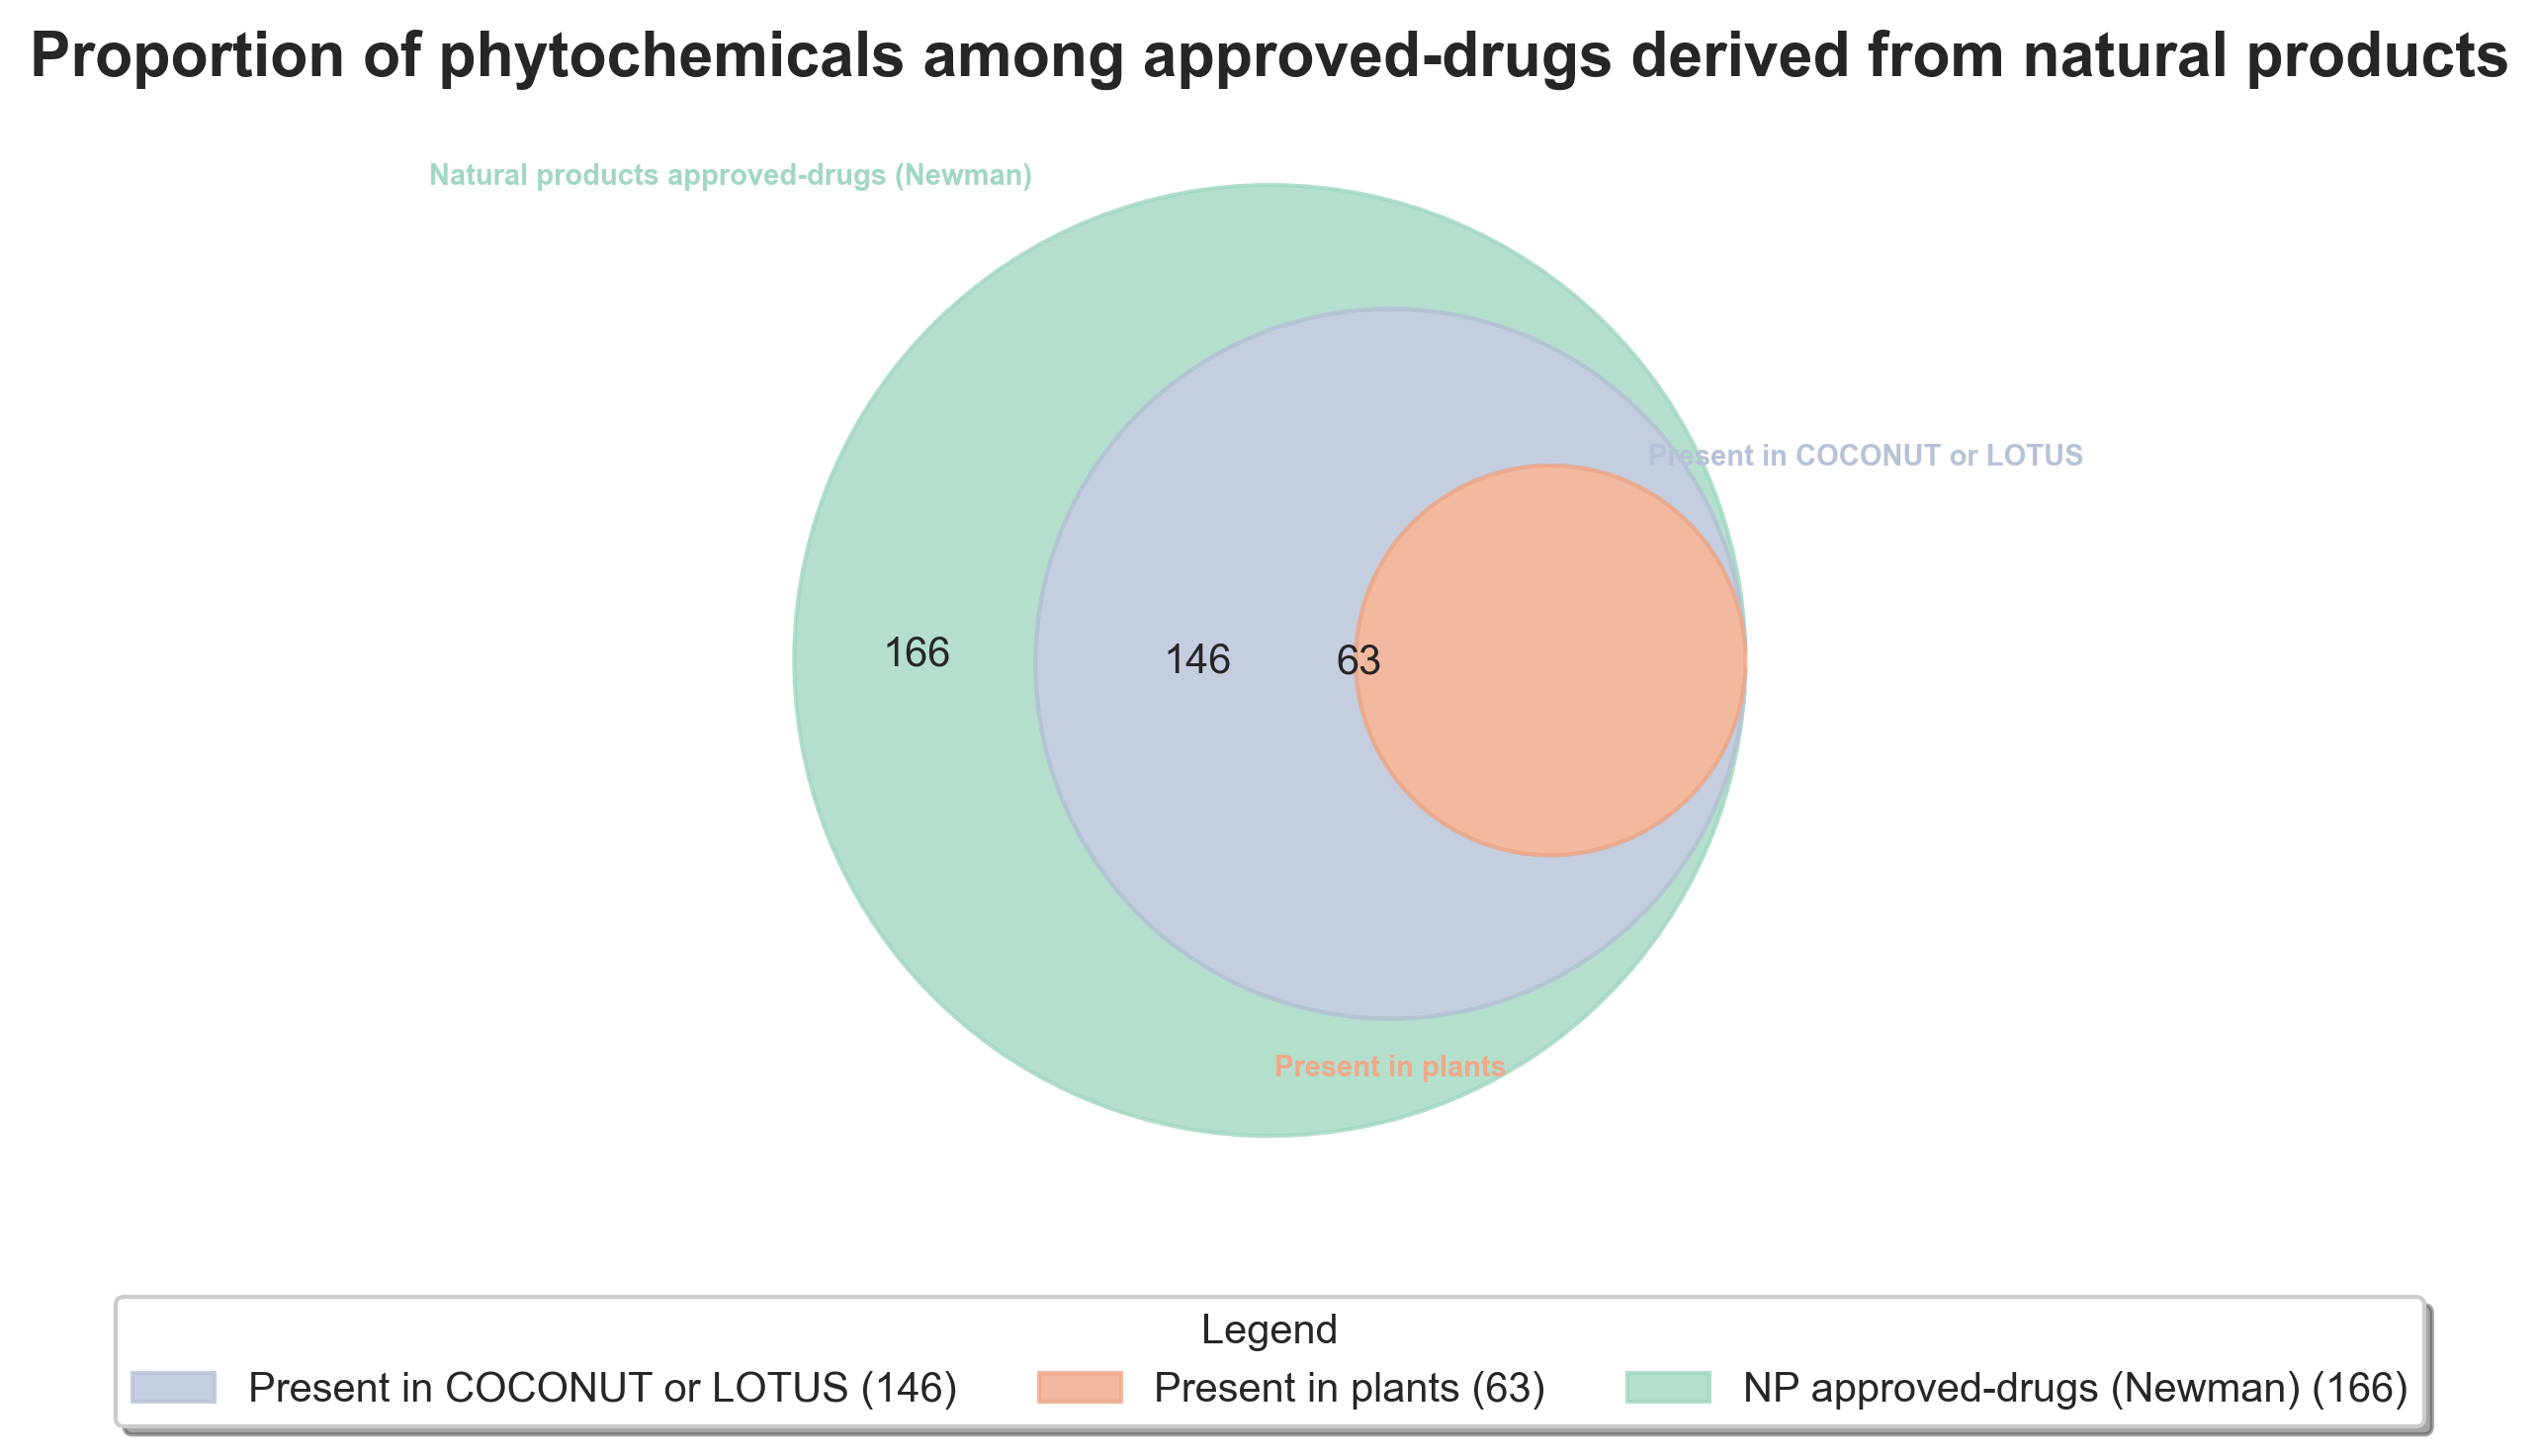

In [29]:
plt.figure(dpi=300, figsize=([5, 5]))

ax = plt.gca()

v = venn3([
    natural_products_newman_inchikeys,  # Newman NPs (outter circle)
    {
        inchikey
        for inchikey in phytochemicals_inchikey
        if inchikey in natural_products_newman_inchikeys
    }, # Chemicals in plants present in Newman NPs
    {
        inchikey
        for inchikey in all_natural_products_inchikeys
        if inchikey in natural_products_newman_inchikeys
    } # COCONUT + LOTUS matching inchikeys
    ],
    set_labels = ('Natural products approved-drugs (Newman)', 'Present in COCONUT or LOTUS', 'Present in plants'),
    alpha=.8,
)
plt.title('Proportion of phytochemicals among approved-drugs derived from natural products', fontsize=15, fontweight='bold')

v.get_patch_by_id('100').set_color('#a2d7c1')
v.get_patch_by_id('101').set_color('#b7c2d7')
v.get_patch_by_id('111').set_color('#efa888')

name_mapping = {
    '100': 'NP approved-drugs (Newman)',
    '101':  'Present in COCONUT or LOTUS',
    '111': 'Present in plants',
}

"""Set labels to empty string and set font size and weight"""
for text in v.set_labels:

    if text.get_text() == 'Natural products approved-drugs (Newman)':
        text.set_color('#a2d7c1')

    elif text.get_text() == 'Present in COCONUT or LOTUS':
        text.set_color('#b7c2d7')

    elif text.get_text() == 'Present in plants':
        text.set_color('#efa888')

    # text.set_text('')
    text.set_fontweight('bold')
    text.set_fontsize(7)

h, l = [],[]
for i in [
    '100',
    '101',
    '111',
]:
    # remove label by setting them to empty string:
    label = v.get_label_by_id(i)
    
    l.append(
        f"{name_mapping[i]}"
    )

    # label.set_text("")

    # append patch to handles list
    h.append(v.get_patch_by_id(i))

#create legend from handles and labels    
ax.legend(handles=h, labels=l, title="Legend", loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.show()

The Venn diagram confirms that the phytochemicals overlapping with approved-drugs in DrugBank corresponds to the same ones overlapping to approved-drugs in Newman

In [50]:
inchikey_to_pubchem = defaultdict(set)

for pubchem, inchikey in pubchem_to_inchikey.items():
    inchikey_to_pubchem[get_first_part_inchikey(inchikey)].add(pubchem)

phytochemicals_pubchems_set = {
    pubchem
    for inchikey in phytochemicals_inchikey
    if inchikey in natural_products_newman_inchikeys
    for pubchem in inchikey_to_pubchem[inchikey]
}

chemical_to_plants = defaultdict(set)

for plant, chemical in plant_chemical_df.values:
    chemical_to_plants[chemical].add(plant)

medicinal_plants_with_approved_drugs = set()
non_medicinal_plants_with_approved_drugs = set()

for pubchem in tqdm(phytochemicals_pubchems_set):

    for plant in chemical_to_plants[pubchem]:
        if plant in medicinal_plants:
            medicinal_plants_with_approved_drugs.add(pubchem)
        else:
            non_medicinal_plants_with_approved_drugs.add(pubchem)

print(f"Medicinal plants with approved drugs: {len(medicinal_plants_with_approved_drugs)}")
print(f"Non-medicinal plants with approved drugs: {len(non_medicinal_plants_with_approved_drugs)}")

del phytochemicals_pubchems_set, inchikey_to_pubchem, chemical_to_plants, medicinal_plants_with_approved_drugs, non_medicinal_plants_with_approved_drugs

100%|██████████| 81/81 [00:00<00:00, 526.95it/s]

Medicinal plants with approved drugs: 74
Non-medicinal plants with approved drugs: 35


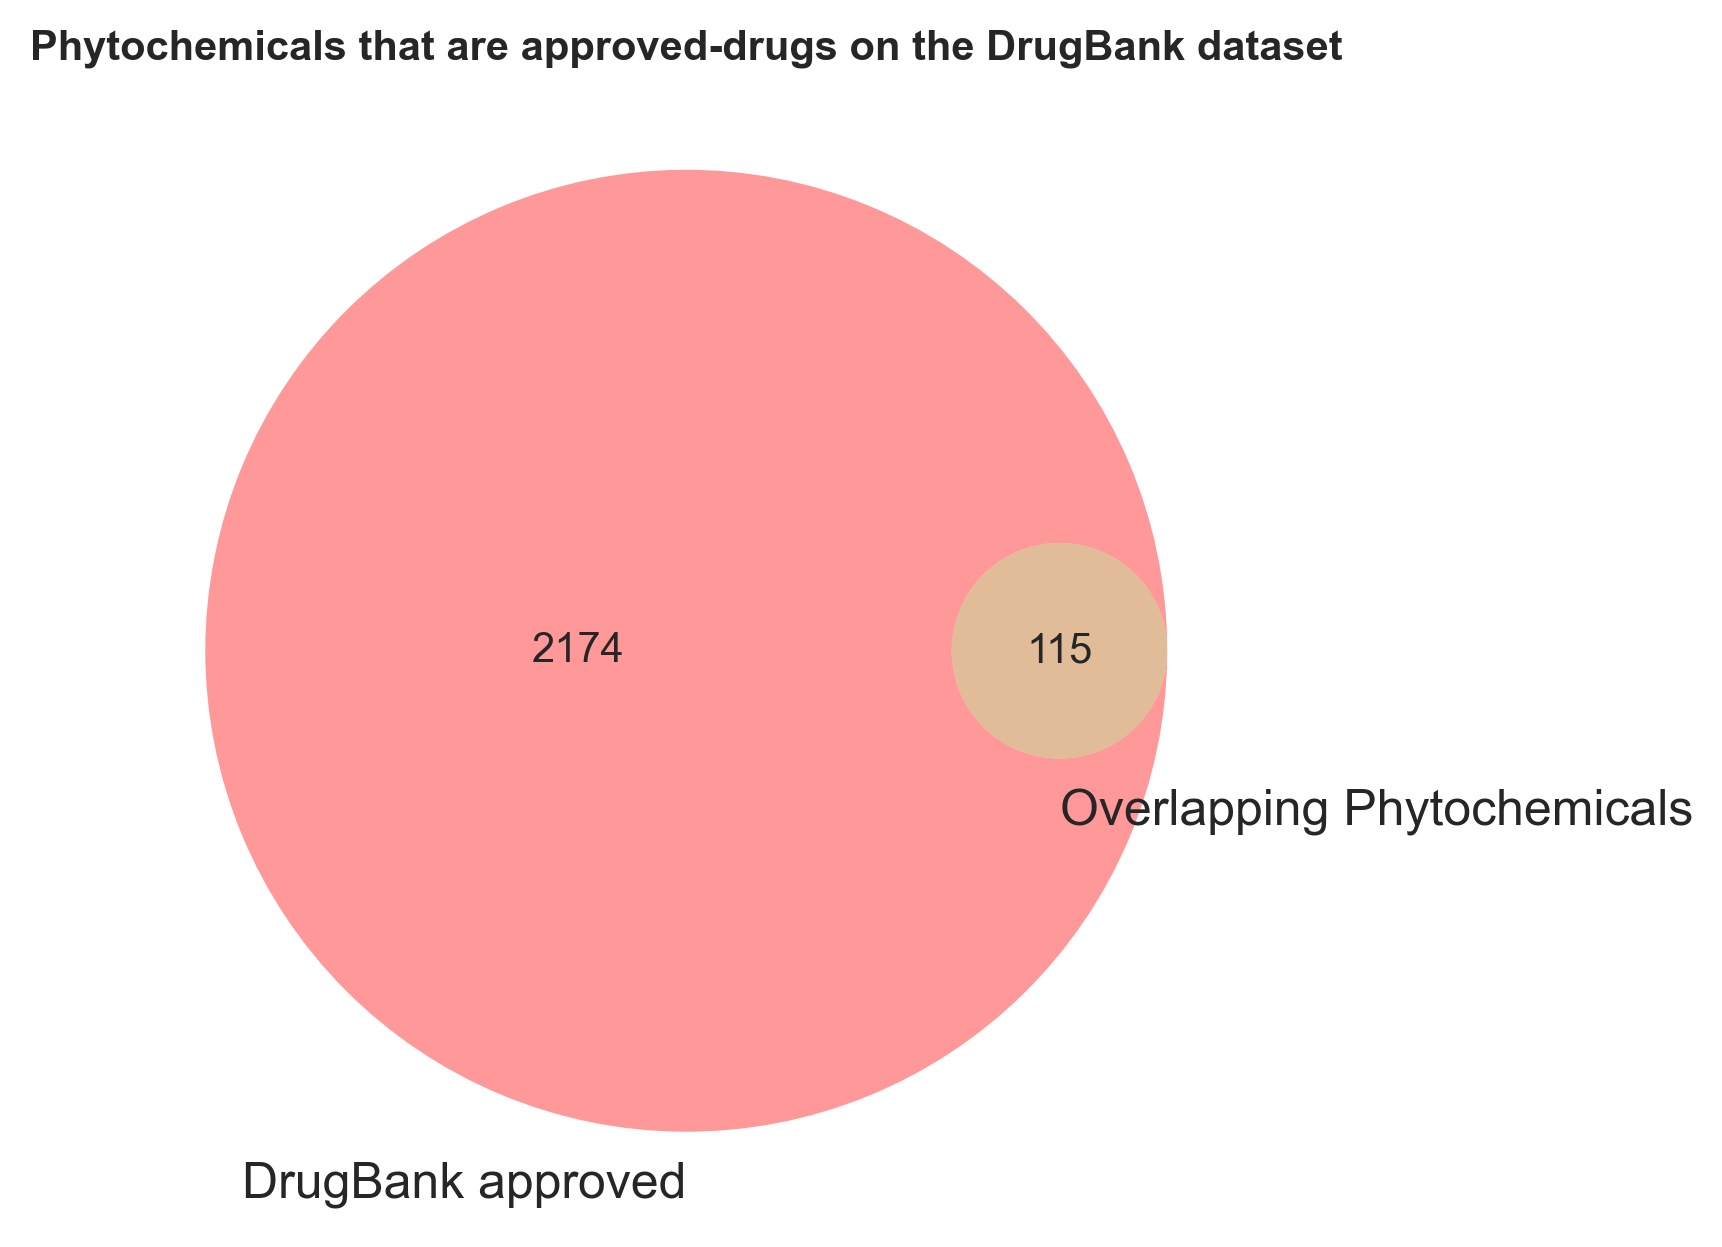

In [30]:
plt.figure(dpi=300, figsize=([5, 5]))
v = venn2([drugbank_inchikeys, {
        inchikey
        for inchikey in phytochemicals_inchikey
        if inchikey in drugbank_inchikeys
    }], set_labels = ('DrugBank approved', 'Overlapping Phytochemicals')
)
plt.title('Phytochemicals that are approved-drugs on the DrugBank dataset', fontsize=10, fontweight='bold')
v.get_label_by_id('010').set_text('')

plt.show()

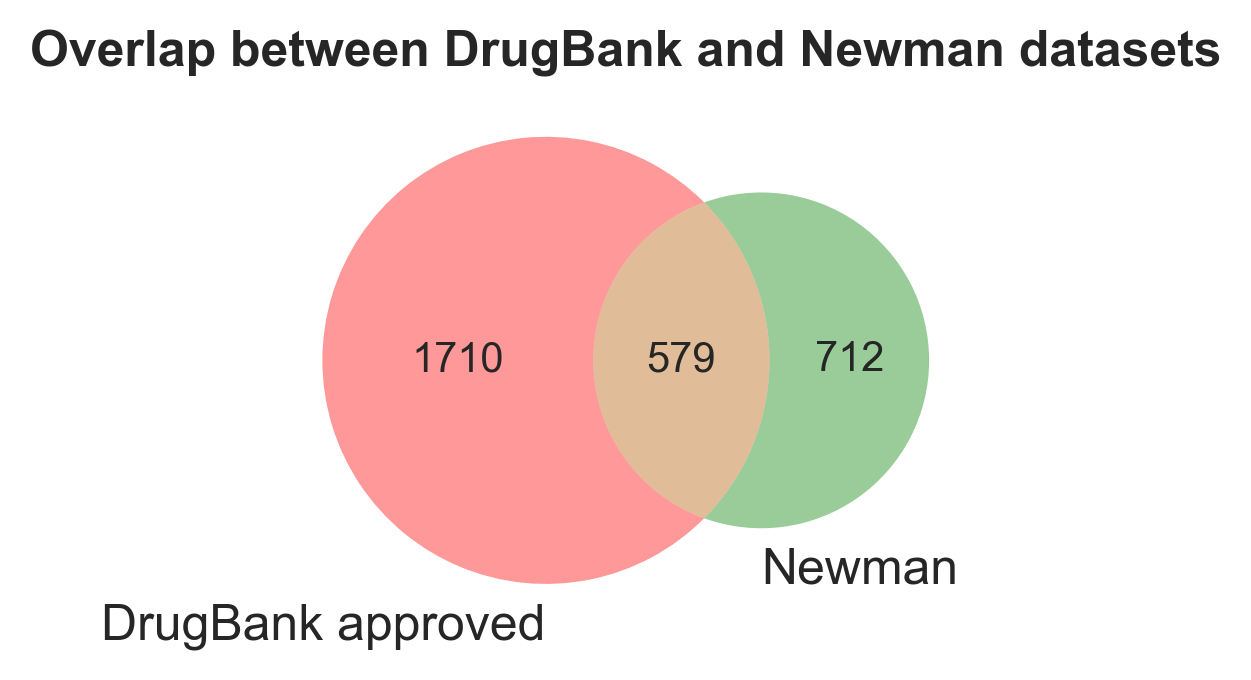

In [31]:
plt.figure(dpi=300, figsize=([3, 3]))
v = venn2([drugbank_inchikeys, synthethics_inchikeys.union(natural_products_newman_inchikeys)], set_labels = ('DrugBank approved', 'Newman')
)
plt.title('Overlap between DrugBank and Newman datasets', fontsize=12, fontweight='bold')

plt.show()

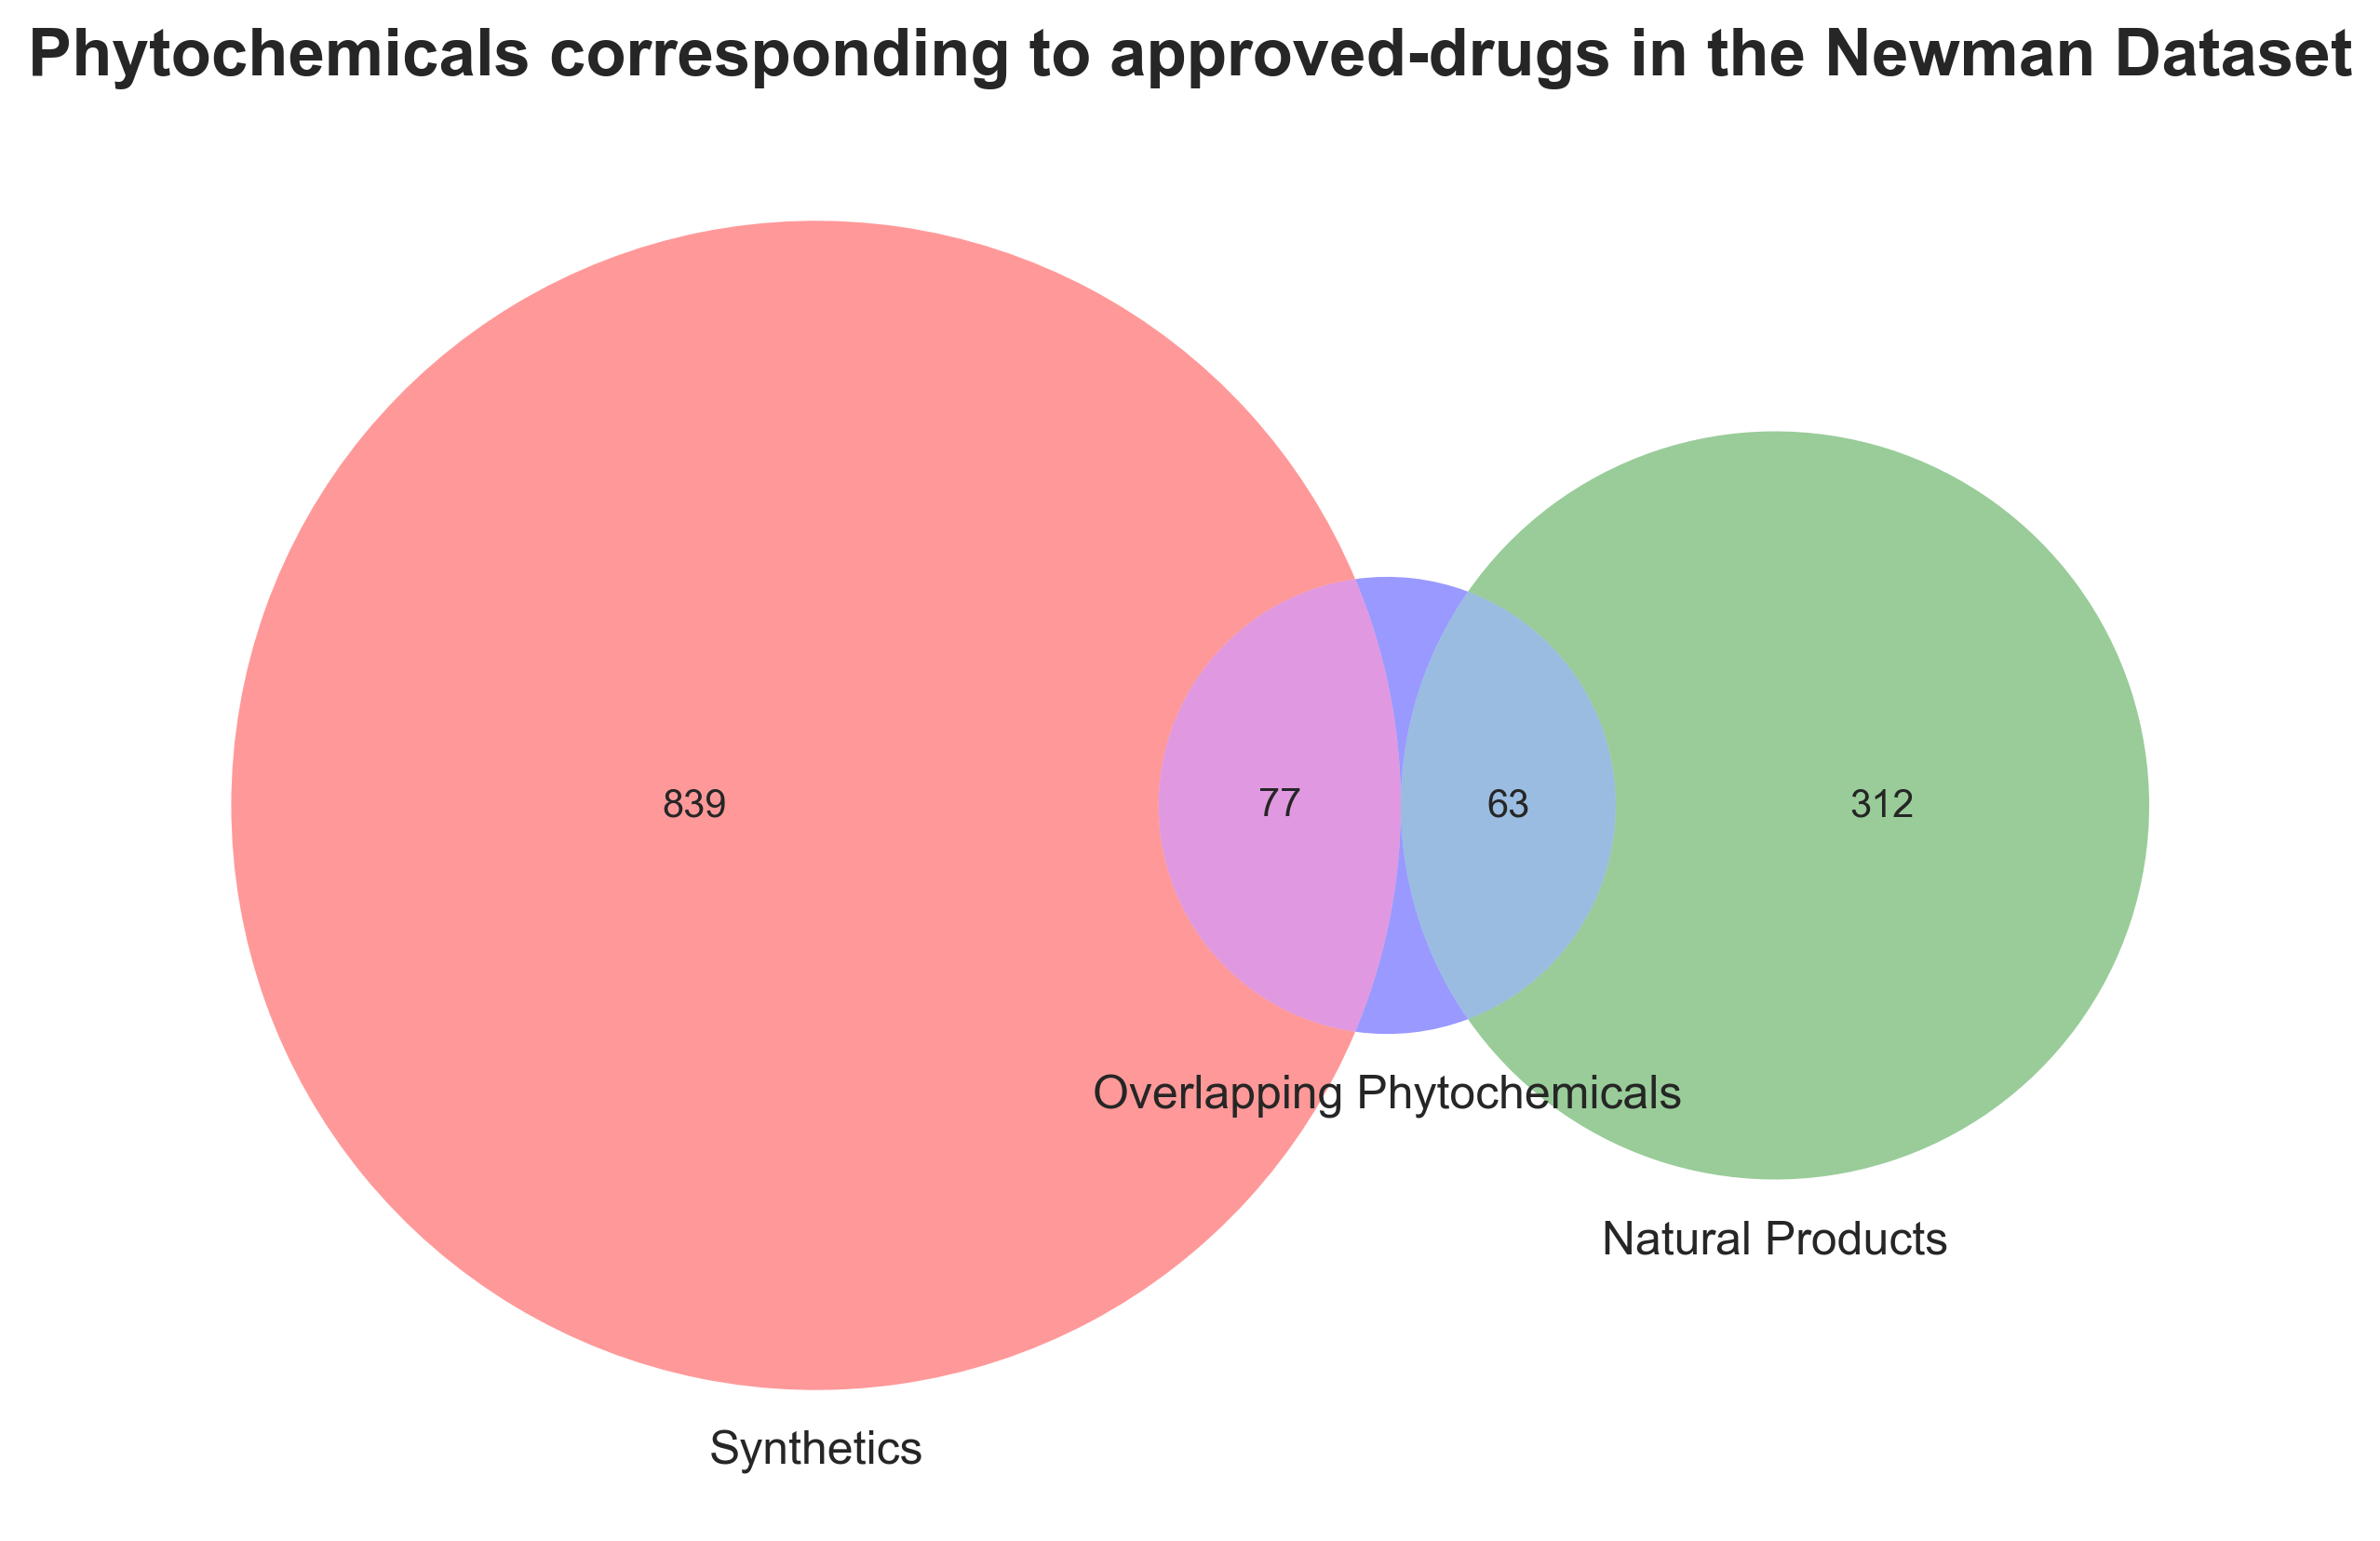

In [33]:
plt.figure(dpi=300, figsize=([10, 10]))
v = venn3([synthethics_inchikeys, natural_products_newman_inchikeys, phytochemicals_inchikey], set_labels = ('Synthetics', 'Natural Products', 'Overlapping Phytochemicals'))
plt.title('Phytochemicals corresponding to approved-drugs in the Newman Dataset', fontsize=17, fontweight='bold')

# Remove the count for phytochemicals that are not in the other sets since we remove that
v.get_label_by_id('001').set_text('')

plt.show()

In [34]:
dump_df = pd.DataFrame([
    {
        'type': 'np' if inchikey in natural_products_newman_inchikeys else 'synthetic' if inchikey in synthethics_inchikeys else '-',
        'name': synthethics_inchikeys_dict[inchikey] if inchikey in synthethics_inchikeys_dict else natural_products_inchikeys_dict[inchikey],
        'smiles': get_compounds(inchikey, 'inchikey')[0].canonical_smiles,
    }
    for inchikey in tqdm(natural_products_newman_inchikeys.intersection(phytochemicals_inchikey).union(
        synthethics_inchikeys.intersection(phytochemicals_inchikey)
    ))
])

dump_df['Mol Image'] = [Chem.MolFromSmiles(s) for s in dump_df['smiles']]

PandasTools.SaveXlsxFromFrame(dump_df, 'overlapping_phytochemicals.xlsx', molCol='Mol Image')

100%|██████████| 140/140 [07:18<00:00,  3.13s/it]


### Murcko scaffolds

In [35]:
def get_murcko_scaffolds(smiles, skipped):
    try:
        molecule = MolFromSmiles(smiles)
    except:
        skipped += 1

    return Chem.MolToSmiles(GetScaffoldForMol(molecule))

synthethics_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in tqdm(synthetics_df.smiles.values)
    if smiles
}

# Remove the empty ones filtered out before
synthethics_murcko = {
    smiles
    for smiles in synthethics_murcko
    if smiles
}

natural_products_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in tqdm(natural_products_df.smiles.values)
    if smiles
}

# Remove the empty ones filtered out before
natural_products_murcko = {
    smiles
    for smiles in natural_products_murcko
    if smiles
}

phytochemicals_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in tqdm(smiles_to_pubchem.keys())
}

# Get the ones in the other sets to reduce the number and make a better plot
phytochemicals_murcko = {
    murcko
    for murcko in phytochemicals_murcko
    if murcko in synthethics_murcko or murcko in natural_products_murcko
    if murcko
}

# Remove the empty ones filtered out before
phytochemicals_murcko = {
    smiles
    for smiles in phytochemicals_murcko
    if smiles
}

100%|██████████| 89270/89270 [01:07<00:00, 1317.22it/s]


In [36]:
skipped

0

/Users/danieldomingo/anaconda3/envs/kg-analysis/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


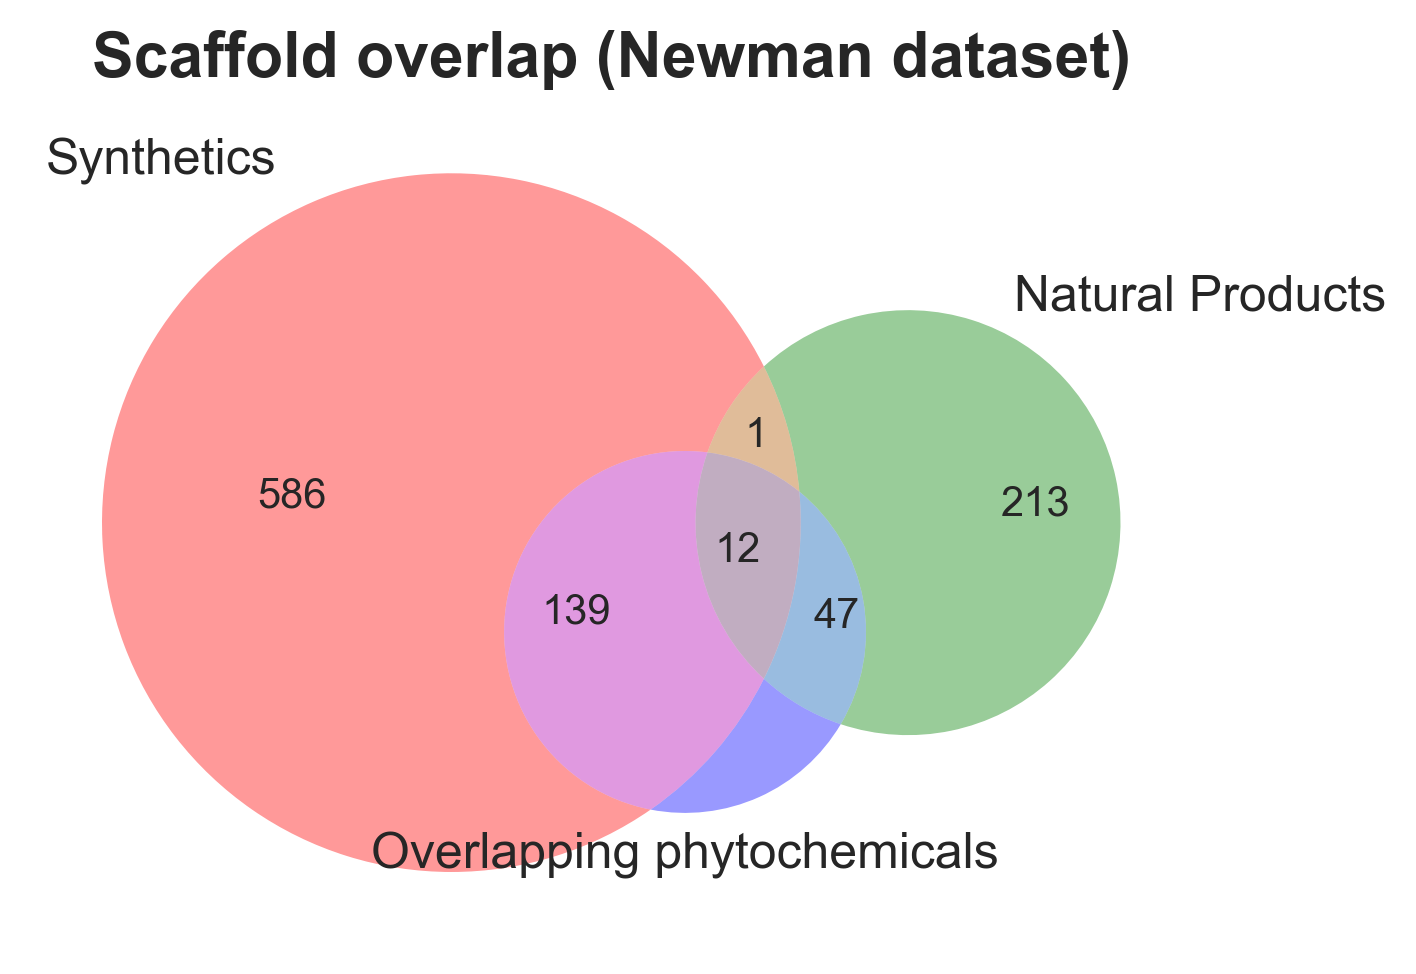

In [37]:
plt.figure(dpi=300, figsize=([5,5]))
v = venn3([synthethics_murcko, natural_products_murcko, phytochemicals_murcko], set_labels = ('Synthetics', 'Natural Products', 'Overlapping phytochemicals'))

# Remove the count for phytochemicals that are not in the other sets since we remove that
v.get_label_by_id('001').set_text('')

plt.title('Scaffold overlap (Newman dataset)', fontsize=15, fontweight='bold')

plt.show()

Scaffolds in all the three sets

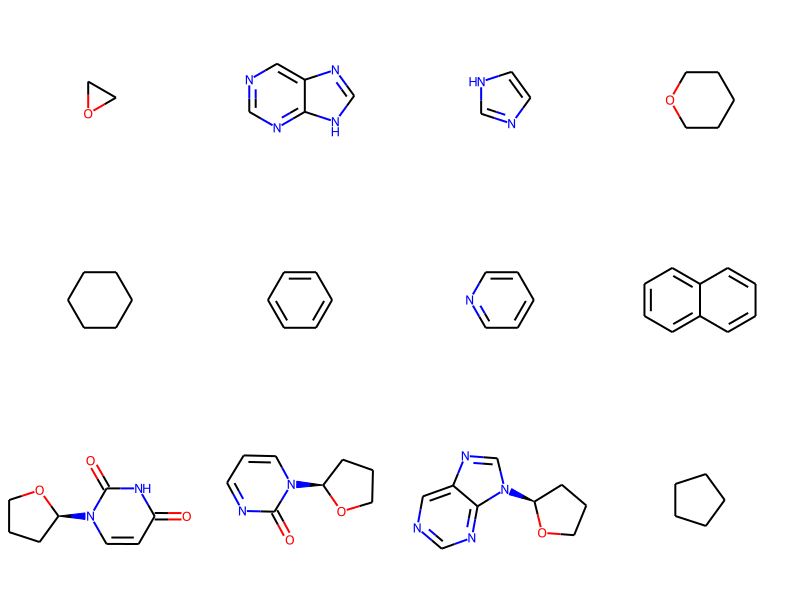

In [38]:
Chem.Draw.MolsToGridImage(
    [
        MolFromSmiles(smiles)
        for smiles in synthethics_murcko.intersection(natural_products_murcko).intersection(phytochemicals_murcko)
        if smiles
    ],
    molsPerRow=4,
    subImgSize=(200,200),
)    

Scaffolds in NPs overlapping with phytochemicals

/Users/danieldomingo/anaconda3/envs/kg-analysis/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


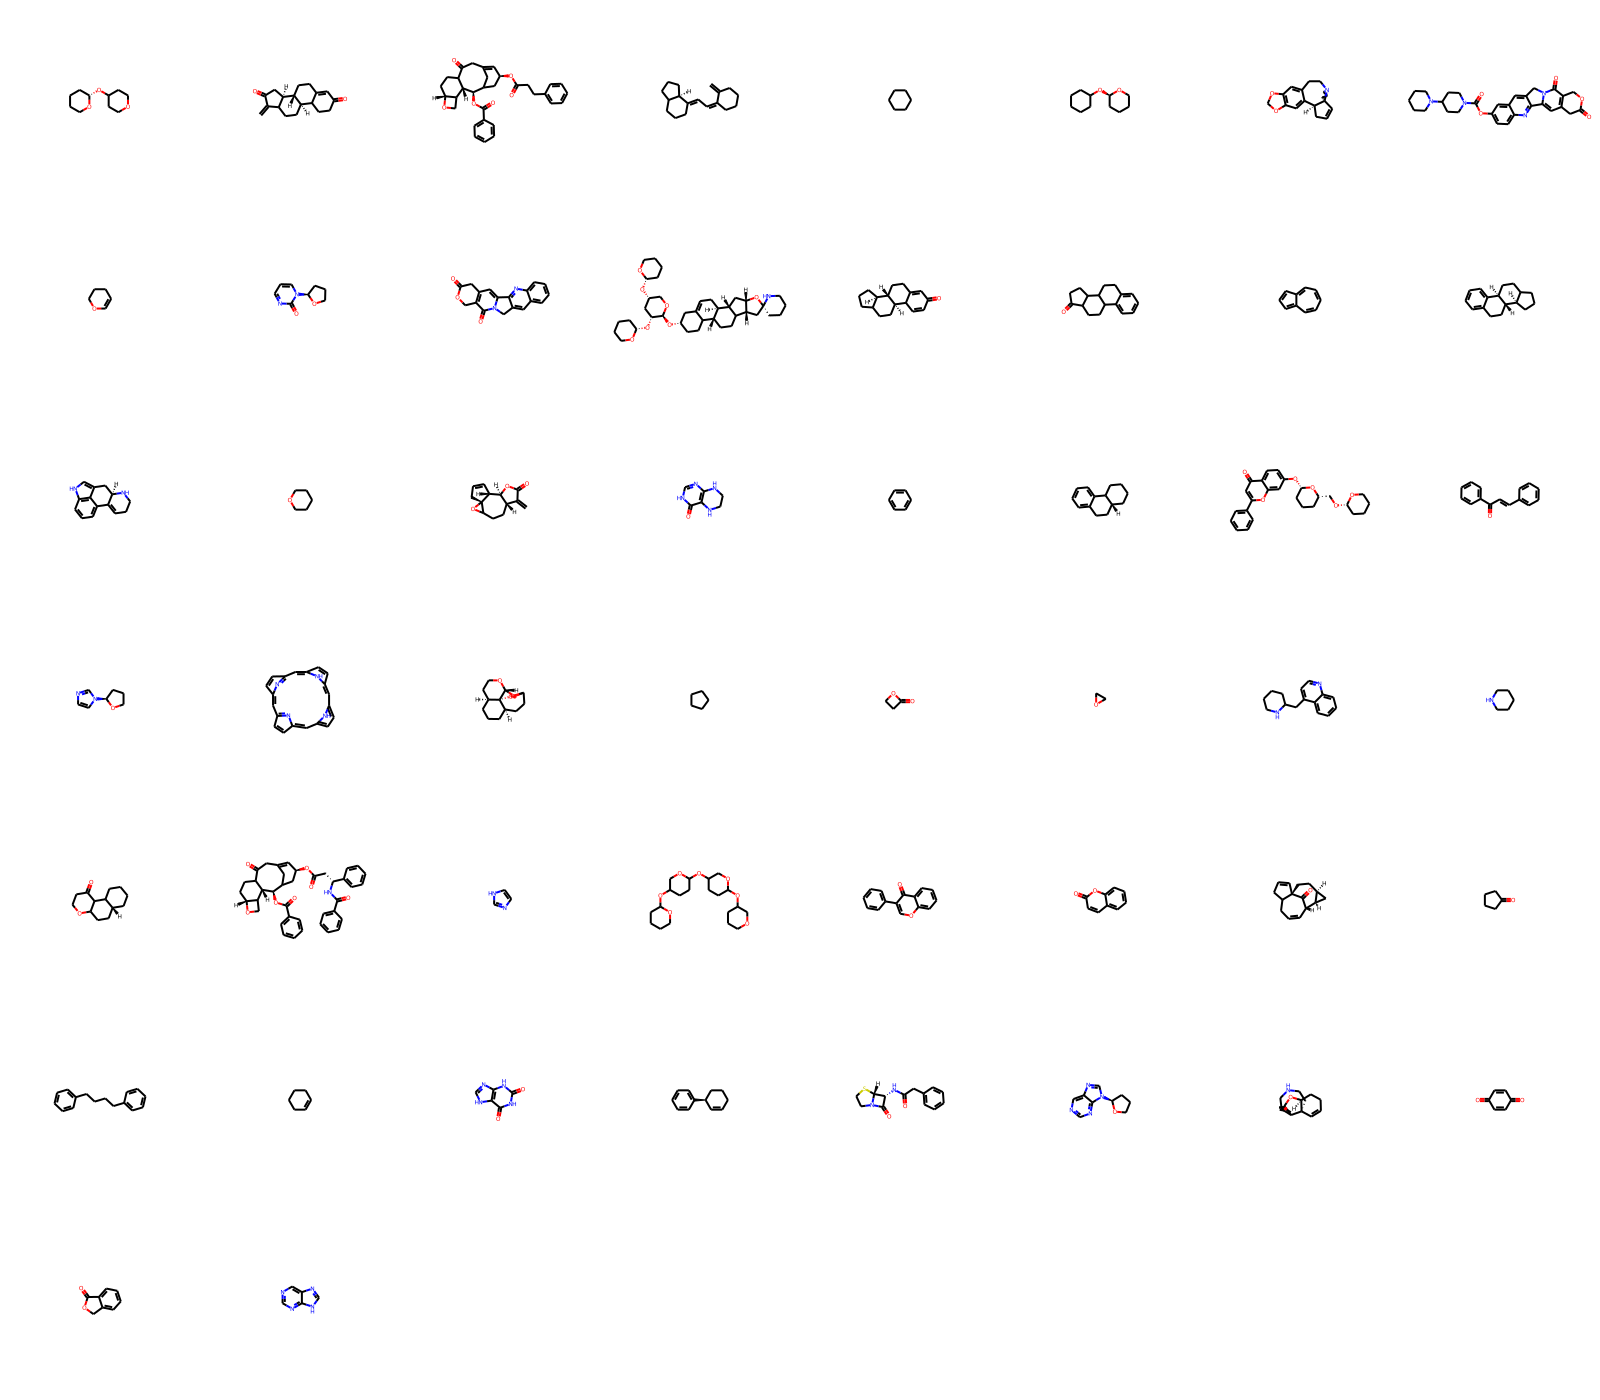

In [39]:
Chem.Draw.MolsToGridImage(
    [
        MolFromSmiles(smiles)
        for smiles in natural_products_murcko.intersection(phytochemicals_murcko)
        if smiles
    ],
    molsPerRow=8,
    subImgSize=(200,200),
)

Scaffolds in Synthetics subset overlapping with phytochemicals

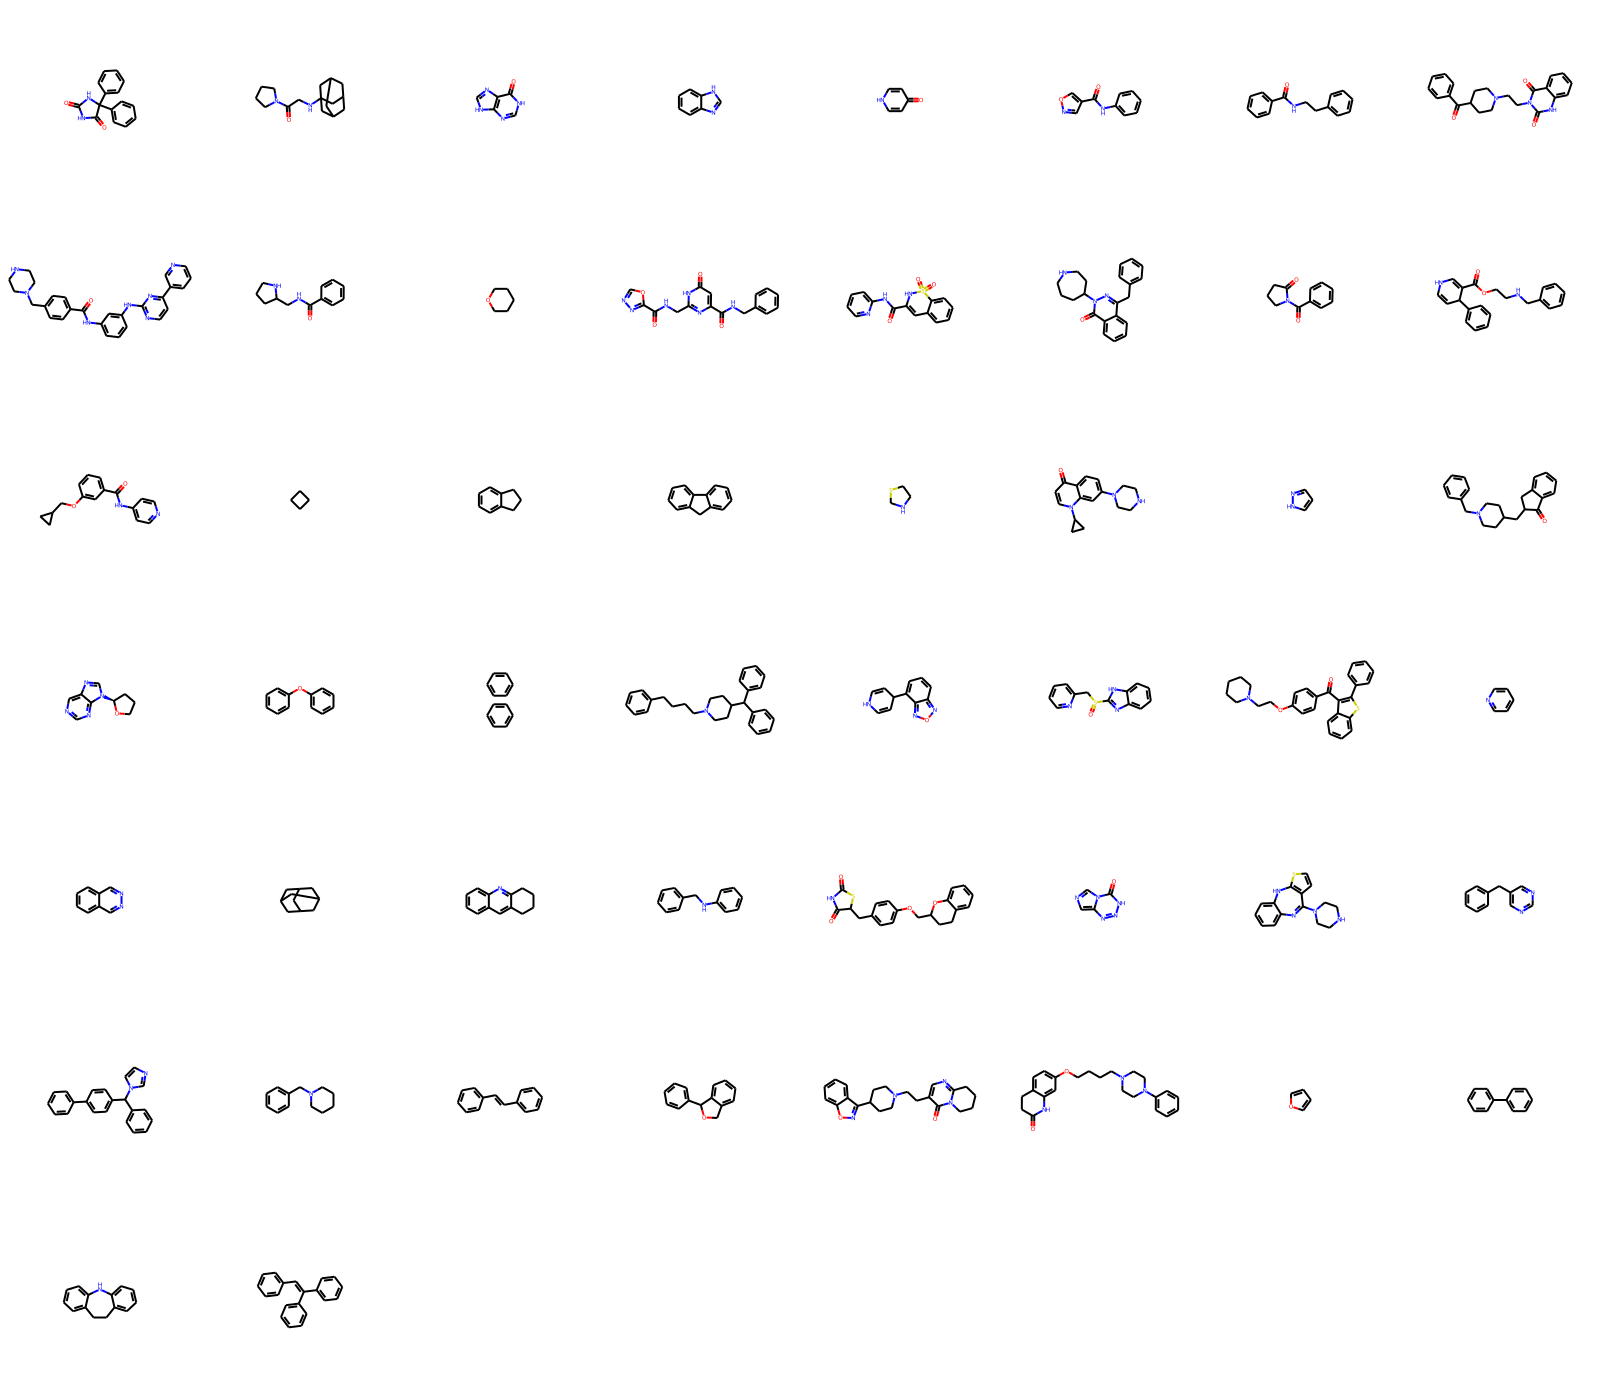

In [40]:
Chem.Draw.MolsToGridImage(
    [
        MolFromSmiles(smiles)
        for smiles in synthethics_murcko.intersection(phytochemicals_murcko)
        if smiles
    ],
    molsPerRow=8,
    subImgSize=(200,200),
)